# Ideation



In [1]:
import yfinance as yf
import pandas as pd
from helper import get_tickers, get_extreme
from portfolio import MomentumPortfolio
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

lowess = sm.nonparametric.lowess



In [2]:
tickers = get_tickers()

# just use first one for ideation
data = pd.DataFrame(yf.Ticker(tickers[0]).history(period = "10y")["Close"])
data.head()


,Close
Date,
2016-02-04 00:00:00-05:00,43.079193
2016-02-05 00:00:00-05:00,42.361069
2016-02-08 00:00:00-05:00,41.667702
2016-02-09 00:00:00-05:00,41.436584
2016-02-10 00:00:00-05:00,41.428333


In [3]:
data["100dma"] = data[["Close"]].rolling("100D").mean()
data["100dms"] = data[["Close"]].rolling("100D").std()
data.tail()


,Close,100dma,100dms
Date,,,
2026-01-28 00:00:00-05:00,146.839996,141.101488,2.751172
2026-01-29 00:00:00-05:00,146.699997,141.223633,2.812865
2026-01-30 00:00:00-05:00,145.500000,141.336150,2.828837
2026-02-02 00:00:00-05:00,146.309998,141.474685,2.886548
2026-02-03 00:00:00-05:00,145.539993,141.534469,2.907032


In [4]:
data["z"] = (data["Close"] - data["100dma"])/data["100dms"]
data.sample(5)
# higher z more expensive, lower z cheaper


,Close,100dma,100dms,z
Date,,,,
2016-11-08 00:00:00-05:00,48.690403,48.971456,0.524210,-0.536145
2023-03-07 00:00:00-05:00,84.153946,83.928538,2.257934,0.099829
2025-01-06 00:00:00-05:00,117.364433,117.130844,1.428225,0.163552
2025-10-14 00:00:00-04:00,136.480881,132.653527,3.392155,1.128296
2024-12-30 00:00:00-05:00,115.898735,117.106899,1.425243,-0.847690


Lowess curve to find trend. 

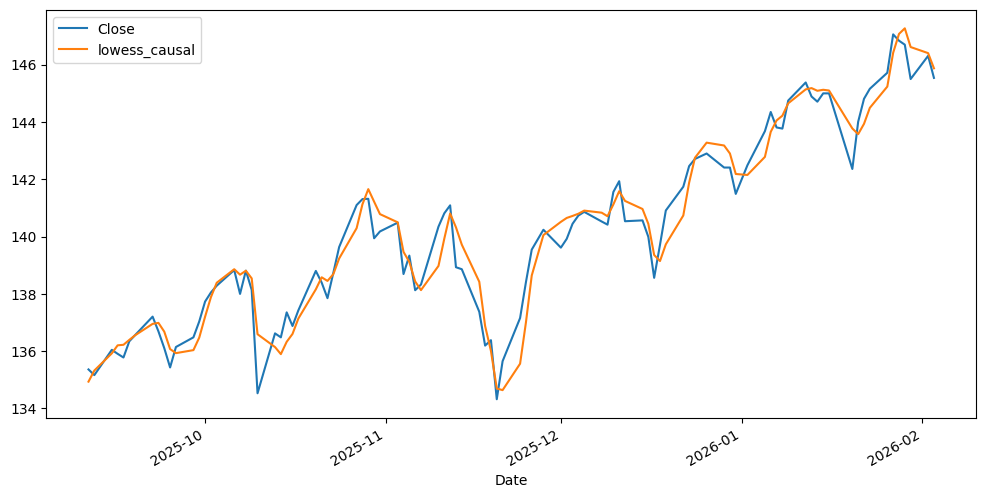

In [5]:
window_size = 100 

def get_causal_lowess(window):
    # This function takes the current window and returns ONLY the last smoothed point
    # frac=0.1 means it uses 10% of the window to smooth the final point
    res = lowess(window, np.arange(len(window)), frac=0.1, it=0)
    return res[-1, 1]  # Return the last smoothed value (the current day)

# 2. Apply it using a rolling window
# This ensures each 'lowess' value only knows about the past
data["lowess_causal"] = data["Close"].rolling(window=window_size).apply(get_causal_lowess)
data["lowess_gradient"] = np.gradient(data["lowess_causal"])
plt.figure(figsize=(12, 6))
ax = plt.gca() 
data.tail(100).plot(y = "Close", ax = ax)
data.tail(100).plot(y = "lowess_causal", ax = ax)
plt.show()


In [6]:
data.sample(5)


,Close,100dma,100dms,z,lowess_causal,lowess_gradient
Date,,,,,,
2022-06-09 00:00:00-04:00,83.687149,87.940027,3.913461,-1.086731,84.874092,-1.505957
2017-11-03 00:00:00-04:00,60.245274,58.372610,1.101661,1.699855,60.274285,0.105177
2020-09-01 00:00:00-04:00,75.503708,69.874944,2.955134,1.904740,75.453327,0.338840
2020-01-23 00:00:00-05:00,72.959328,69.697386,1.967704,1.657740,73.056011,-0.204594
2022-05-26 00:00:00-04:00,84.566032,88.710563,4.032216,-1.027854,83.861711,1.237023


In [7]:
get_extreme(data.tail(50))



(np.float64(147.05999755859375), 10)

So now two strats, one shorting when z is low and buying when z is high and other doing the opposite? How to implement percentage retracement

In [8]:
trade_data = data.dropna()
portfolio = MomentumPortfolio()
hist = []
trade_data = trade_data.reset_index()
for i in range(100, trade_data.shape[0]):
    curr_data = trade_data.iloc[i - 100: i]
    day = curr_data.iloc[-1]
    
    transaction = None
    if day["z"] < -2 and not portfolio.holding():
        extreme_price = get_extreme(curr_data)[0]
        transaction = portfolio.buy(day["Close"], 10, extreme_price)
    elif day["z"] > 2 and not portfolio.holding():
        extreme_price = get_extreme(curr_data)[0]
        transaction = portfolio.sell(day["Close"], 10, extreme_price)
    
    # Try to close position on each iteration
    close_result = portfolio.close(day["Close"])
    if close_result:
        transaction = close_result
    
    value = portfolio.get_value(day["Close"])
    hist.append([day["Date"], transaction, value])

hist = pd.DataFrame(hist, columns = ["Date", "Transaction", "Value"])


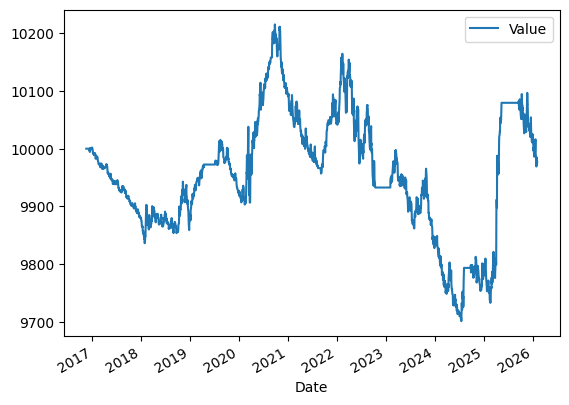

In [9]:
hist.plot(x = "Date", y = "Value")
plt.show()


In [10]:
hist["daily_return"] = hist["Value"].pct_change()
hist["daily_return"].mean()/hist["daily_return"].std() * np.sqrt(252)


np.float64(-0.013054061871898712)